# Coursera Data Science CapStone Project

The following notebook is made for the description of the Capstone project. It is part of the IBM Data Science Professional Certification. 

## Introduction
| Description of the Problem and a discussion of the background

Violent crimes, thefts, and robberies occur in majority of places. On daily basis, local businesses, houses etc encounter such crimes. Our job as data scientist is to analyze the pattern of crimes. study the distribution of types of crime that occur in various part of a particular place. It is important to know where the crimes are happening, usually areas with police stations farther in distance can result into increase crime count.

In this case, I decided to perform statistical analysis and data science on the crimes in the city of chicago.

We will also compare the location of local police station in the area, and their relation with the location of the crimes. 

## Data Understanding
Descrption of Data and how it will be used to solve the problem.

Here in this project, I will utilize the crime dataset & police stations provided by [Chicago Data Portal](https://data.cityofchicago.org/browse?category=Public+Safety&limitTo=datasets). 

Furthermore we will use the Foursquare API to fetch the venues to see in what specific type of environment or location does these crimes take place.

---

### Crime Data Set
The crime data set consist of reported incidents of crime that occurred in the City of Chicago from 2018, The particular data set is subset of a bigger crime data with over 6.9 Million fields which would require greater computation power.. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified

The dataset consist of **22 fields** and over **226K rows**. The fields include attributes related to crime such as *Case number, block, IUCR codes, Description, Type of Crime, location, Lattitude, Longitude, district.*

Since there are many fields that are not required in our analysis, we will require a lot of cleaning to do. 


In [3]:
# importing all the required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sb

!conda install -c conda-forge folium=0.5.0 --yes
import folium
import json
import requests

from geopy.geocoders import Nominatim


print("All the libraries are imported!")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [4]:
# create dataframes
crime = pd.read_csv('https://data.cityofchicago.org/api/views/3i3m-jwuy/rows.csv?accessType=DOWNLOAD')
police_station = pd.read_csv('https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD')

print("Dimensions of crime data set: ", crime.shape)
print("Dimensions of police station data set: ", police_station.shape)

Dimensions of crime data set:  (266982, 30)
Dimensions of police station data set:  (23, 15)


In [158]:
# drop unncessary attributes from crime table
crime_clean = crime.drop(['Arrest','ID','Block','Description','IUCR','Year','Domestic','Beat','Ward',
            'FBI Code','Updated On','Historical Wards 2003-2015',
            'Community Areas','Census Tracts','Wards',
            'Police Beats','X Coordinate','Y Coordinate',
            'Location','Boundaries - ZIP Codes','Police Districts','Zip Codes'],axis=1)

crime_clean = crime_clean.dropna()

crime_clean.head(10)

Case Number                    Date       Primary Type  \
0     JC104662  12/31/2018 11:59:00 PM    CRIMINAL DAMAGE   
2     JC100043  12/31/2018 11:57:00 PM    CRIMINAL DAMAGE   
3     JC100006  12/31/2018 11:56:00 PM            BATTERY   
4     JC100031  12/31/2018 11:55:00 PM            BATTERY   
5     JC100026  12/31/2018 11:49:00 PM            BATTERY   
6     JC100011  12/31/2018 11:48:00 PM            BATTERY   
7     JC100089  12/31/2018 11:47:00 PM            BATTERY   
8     JC101094  12/31/2018 11:45:00 PM              THEFT   
9     JC101652  12/31/2018 11:45:00 PM    CRIMINAL DAMAGE   
10    JB574407  12/31/2018 11:44:00 PM  CRIMINAL TRESPASS   

                                 Location Description  District  \
0                                              STREET        22   
2                                           APARTMENT         6   
3                                               OTHER        12   
4                                           APARTMENT         6   
5                                              STREET        15   
6                                           APARTMENT         6   
7   VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER...        19   
8                                       BAR OR TAVERN        19   
9                                           APARTMENT        14   
10                                MOVIE HOUSE/THEATER        19   

    Community Area   Latitude  Longitude  
0             74.0  41.689079 -87.696064  
2             71.0  41.740521 -87.647391  
3             31.0  41.857068 -87.657625  
4             71.0  41.751914 -87.647717  
5             25.0  41.875684 -87.760479  
6             71.0  41.750154 -87.661009  
7              5.0  41.939625 -87.673996  
8              6.0  41.940519 -87.654124  
9             23.0  41.905562 -87.707589  
10             3.0  41.968463 -87.659670

In [7]:
police_station.drop(['ADDRESS','CITY','WEBSITE','PHONE','FAX','TTY',
                     'LOCATION','X COORDINATE','Y COORDINATE'],axis=1,inplace=True)
police_station.head(5)

DISTRICT   DISTRICT NAME STATE    ZIP   LATITUDE  LONGITUDE
0        1         Central    IL  60616  41.858373 -87.627356
1        2       Wentworth    IL  60609  41.801811 -87.630560
2        3  Grand Crossing    IL  60637  41.766431 -87.605748
3        4   South Chicago    IL  60617  41.707933 -87.568349
4        5         Calumet    IL  60628  41.692723 -87.604506

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


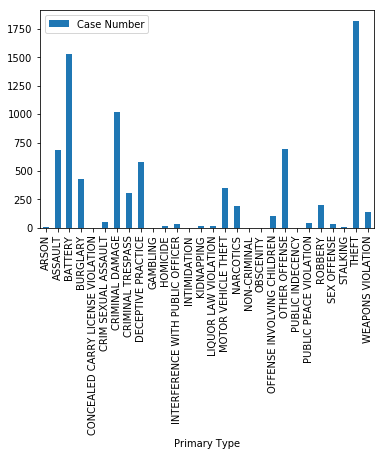

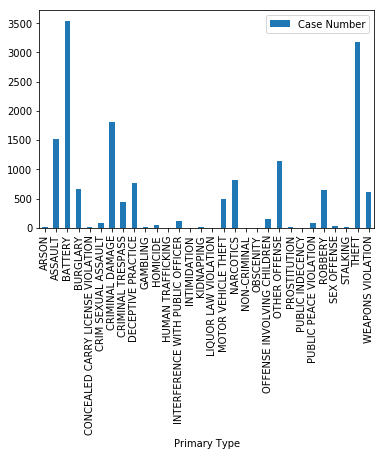

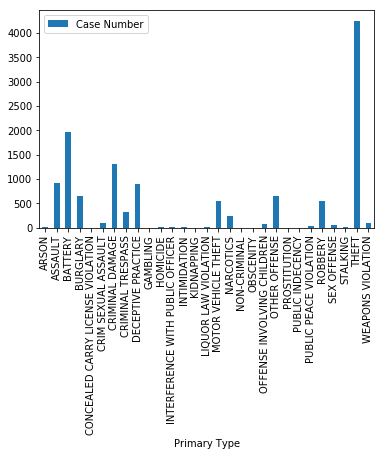

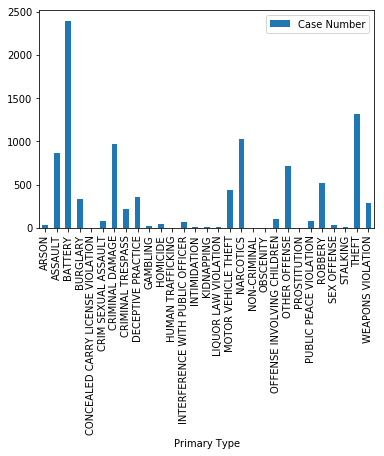

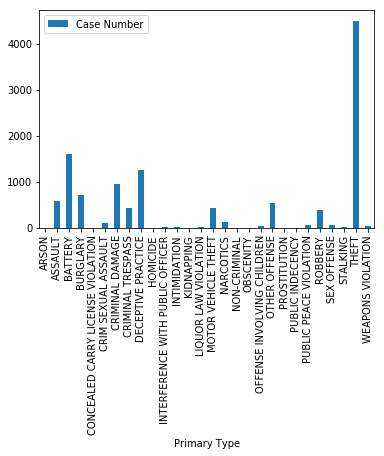

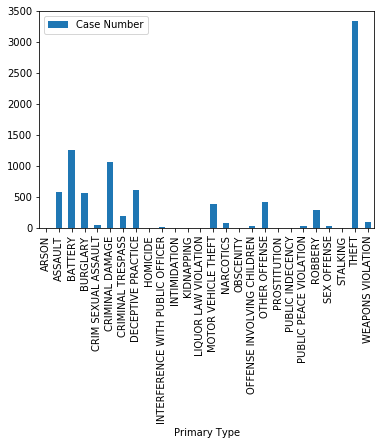

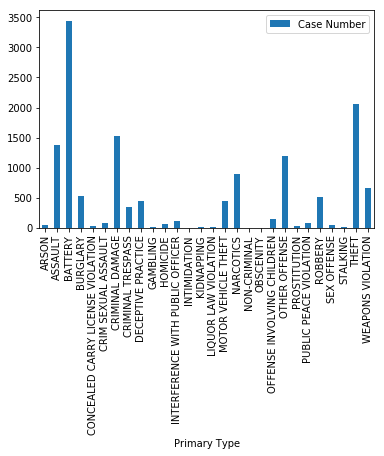

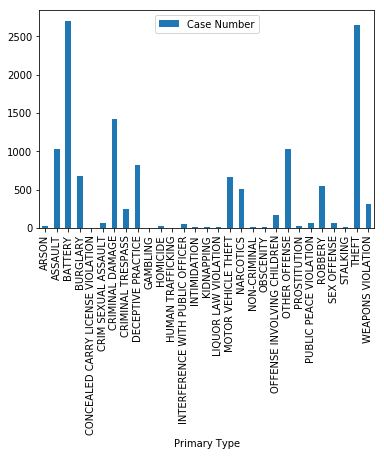

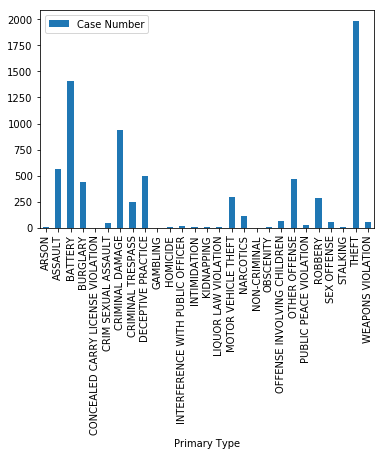

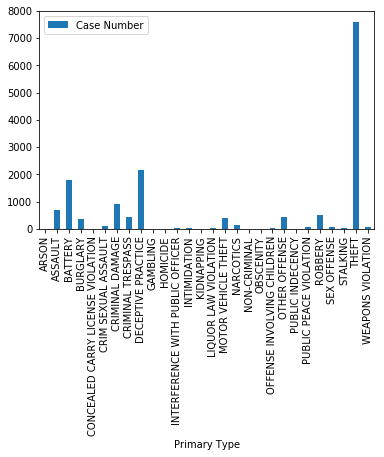

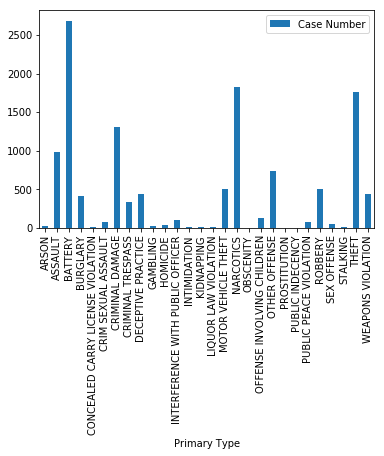

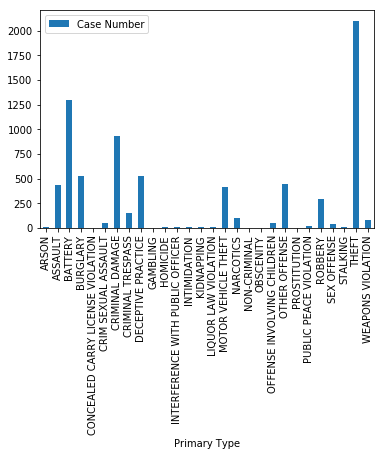

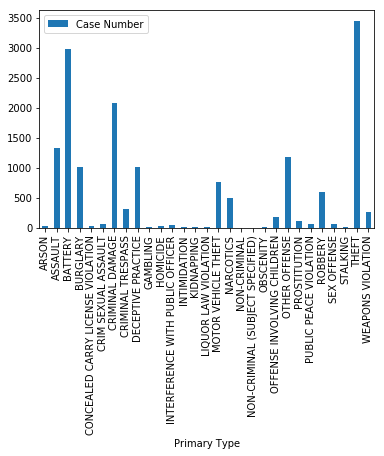

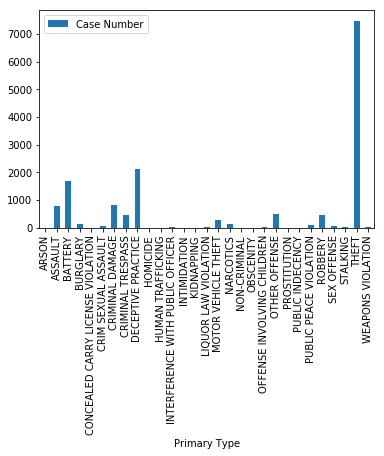

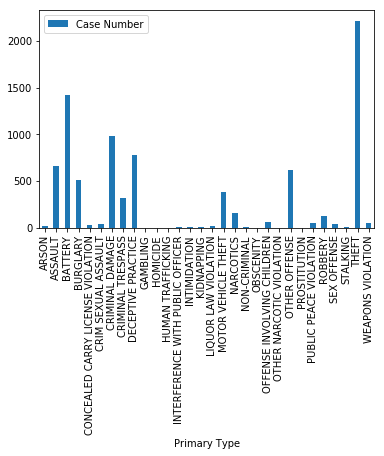

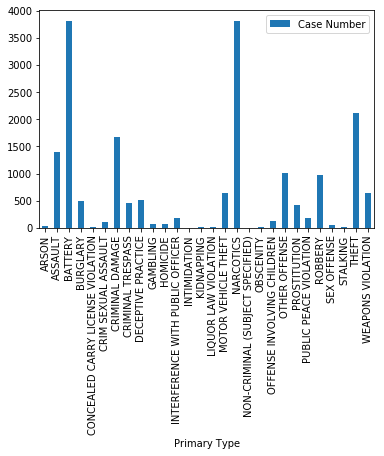

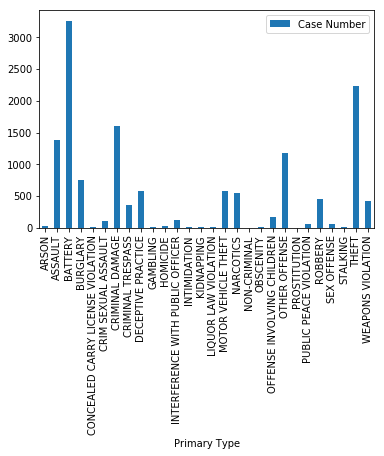

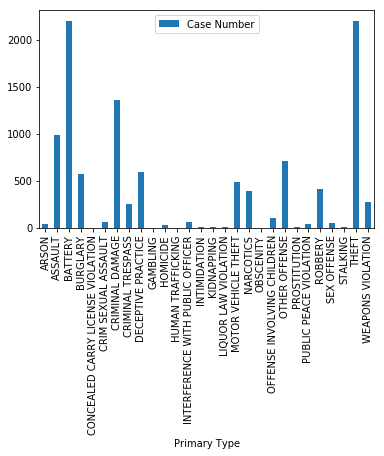

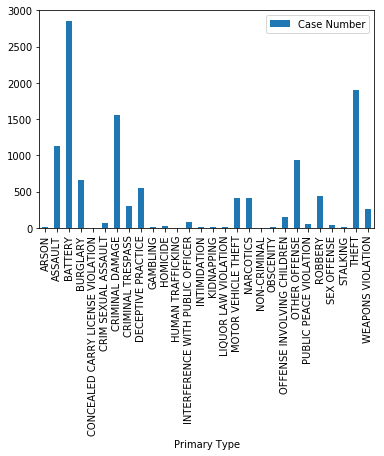

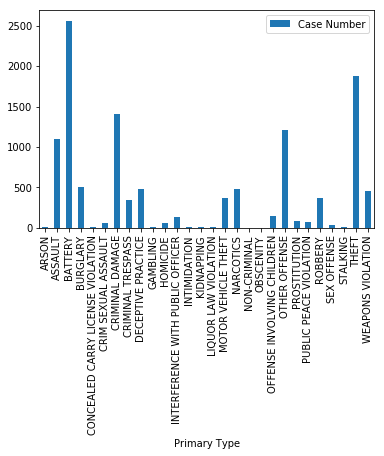

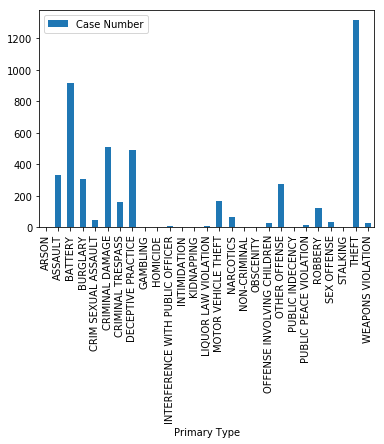

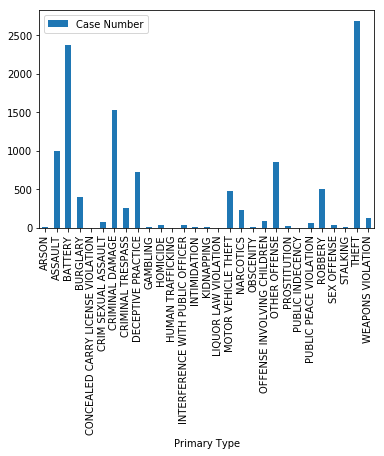

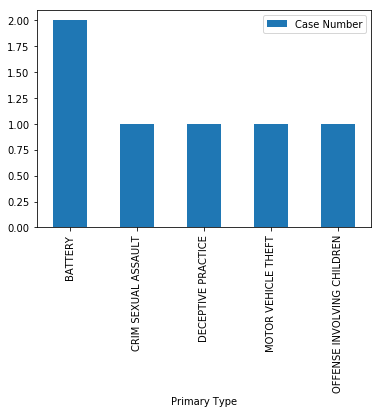

In [175]:
# Lets analyze the crime dataFrame
districts = list(crime_clean['District'].unique())

for dis in districts:
    cnt = crime_clean[crime_clean['District'] == dis]
    bar = cnt[['Case Number','Primary Type']].groupby('Primary Type').count()
    bar.plot.bar()

In [25]:
crime_clean['Primary Type'].head(1000).unique()

array(['CRIMINAL DAMAGE', 'DECEPTIVE PRACTICE', 'BATTERY', 'THEFT',
       'CRIMINAL TRESPASS', 'WEAPONS VIOLATION', 'NARCOTICS', 'ROBBERY',
       'ASSAULT', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT',
       'BURGLARY', 'CONCEALED CARRY LICENSE VIOLATION',
       'CRIM SEXUAL ASSAULT', 'OTHER OFFENSE',
       'OFFENSE INVOLVING CHILDREN', 'HOMICIDE', 'PUBLIC PEACE VIOLATION',
       'KIDNAPPING', 'ARSON', 'SEX OFFENSE'], dtype=object)

### Top Level Map
Here you can see the distribution of various cases that are reported throughout chicago area. The following map will also show the location of various police department in each district

In [178]:
coordinate = [41.8781,-87.6298]

map_cluster = folium.Map(location=[coordinate[0],coordinate[1]],zoom_start = 10.5)

cf = crime[['Latitude','Longitude']]
cf = cf.sample(frac=0.005, random_state=1).dropna()
for lat, long in zip(cf['Latitude'],cf['Longitude']):
    label = folium.CircleMarker(
    [lat,long],radius=2,popup=None,color='blue',fill=True, fill_color='blue').add_to(map_cluster)

    

for lat, long in zip(police_station['LATITUDE'],police_station['LONGITUDE']):
    label = folium.CircleMarker(
    [lat,long],radius=2,popup=None,color='red',fill=True, fill_color='red').add_to(map_cluster)

map_cluster

    

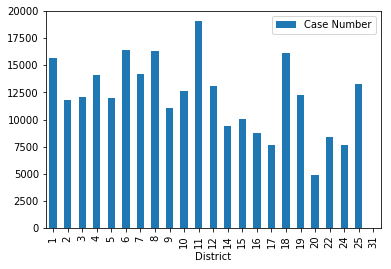

In [48]:
# This graph is to show the relation between each district and the number of recorded cases in 2018 for each of them.
test = crime[['Case Number','District']].groupby('District').count()
test.plot.bar()

### Clustering to check relationship between District and Type of Crimes
In this part, we will analyze the relationship between the type of crimes that exist in each district. Then perfect clustering based on the normalized scores of each primary type of crime. and then plot them on a map shows areas with highest crime rate of a particular type.

In [131]:
# One hot encoding on the Primary Type of Crime record.
onehot = pd.get_dummies(crime_clean[['Primary Type']],prefix="",prefix_sep="")

In [49]:
crime_clean.dtypes

Date                     object
Primary Type             object
Location Description     object
District                  int64
Community Area          float64
Latitude                float64
Longitude               float64
dtype: object

In [50]:
onehot['District'] = crime_clean['District']

In [51]:
cols = list(onehot.columns[-1:]) + list(onehot.columns[:-1])

onehot = onehot[cols]

In [70]:
onehot_mean = onehot.groupby(['District']).mean().reset_index()
onehot_mean

District     ARSON   ASSAULT   BATTERY  BURGLARY  \
0          1  0.000328  0.051669  0.110419  0.009639   
1          2  0.000689  0.086522  0.204929  0.034902   
2          3  0.001174  0.094439  0.239705  0.055271   
3          4  0.001644  0.098449  0.233217  0.054122   
4          5  0.001271  0.093181  0.216942  0.043202   
5          6  0.001106  0.093485  0.217763  0.040750   
6          7  0.002761  0.097635  0.243840  0.036958   
7          8  0.001609  0.081941  0.184614  0.063065   
8          9  0.003405  0.091194  0.202448  0.053005   
9         10  0.001842  0.078581  0.215155  0.033162   
10        11  0.001647  0.074560  0.202742  0.026359   
11        12  0.000780  0.071958  0.153115  0.051142   
12        14  0.000983  0.063818  0.138673  0.062616   
13        15  0.003017  0.087088  0.241050  0.033990   
14        16  0.002457  0.076986  0.166140  0.060138   
15        17  0.000533  0.057977  0.173131  0.069705   
16        18  0.000316  0.042959  0.112768  0.021985   
17        19  0.000419  0.049543  0.134378  0.059938   
18        20  0.000827  0.068046  0.189452  0.063495   
19        22  0.000967  0.083071  0.185248  0.051632   
20        24  0.001193  0.074732  0.186432  0.057904   
21        25  0.002206  0.078369  0.205889  0.051662   
22        31  0.000000  0.000000  0.333333  0.000000   

    CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  CRIMINAL DAMAGE  \
0                            0.000197             0.004721         0.054423   
1                            0.000086             0.006205         0.132282   
2                            0.000252             0.006039         0.130923   
3                            0.000357             0.007149         0.114606   
4                            0.000762             0.004998         0.119441   
5                            0.000799             0.005409         0.111739   
6                            0.002124             0.005239         0.108680   
7                            0.001362             0.004332         0.128172   
8                            0.000184             0.005705         0.124597   
9                            0.000961             0.006248         0.104774   
10                           0.000425             0.005686         0.088643   
11                           0.000312             0.007640         0.102518   
12                           0.000000             0.005136         0.116381   
13                           0.000101             0.007944         0.097043   
14                           0.003042             0.004797         0.114894   
15                           0.000133             0.006131         0.123551   
16                           0.000063             0.006191         0.057742   
17                           0.000168             0.008215         0.079889   
18                           0.000000             0.009100         0.105274   
19                           0.000242             0.005925         0.122612   
20                           0.000133             0.006493         0.124288   
21                           0.000152             0.004870         0.108423   
22                           0.000000             0.166667         0.000000   

    CRIMINAL TRESPASS  DECEPTIVE PRACTICE        ...          \
0            0.029572            0.139007        ...           
1            0.022492            0.062823        ...           
2            0.025497            0.046381        ...           
3            0.025309            0.041753        ...           
4            0.029479            0.040576        ...           
5            0.026613            0.047081        ...           
6            0.024285            0.031577        ...           
7            0.019062            0.062941        ...           
8            0.022821            0.055029        ...           
9            0.026434            0.034764        ...           
10           0.024287            0.026891        ...      

In [42]:
from sklearn.cluster import KMeans

In [59]:
cluster_df = onehot_mean.drop(['District'],1)

In [123]:
kclusters = 6
kmeans = KMeans(n_clusters = kclusters,random_state = 0).fit(cluster_df)
kmeans.cluster_centers_

array([[  7.27417069e-04,   6.17729605e-02,   1.42055433e-01,
          5.78987320e-02,   1.59833618e-04,   6.99715283e-03,
          9.95960648e-02,   2.78951780e-02,   8.10985419e-02,
          1.29934253e-04,   8.69746621e-04,   0.00000000e+00,
          2.05535021e-03,   9.92275089e-04,   2.26158875e-04,
          1.45644964e-03,   4.07328380e-02,   1.24807156e-02,
          1.37759282e-04,   8.47032947e-22,   3.87410251e-04,
          4.28891061e-03,   0.00000000e+00,   4.72405657e-02,
          2.22246360e-04,   1.26781742e-04,   4.03653313e-03,
          3.55158750e-02,   5.08980320e-03,   8.22223933e-04,
          3.57674975e-01,   7.31213360e-03],
       [  2.16889976e-03,   8.00761708e-02,   2.19649160e-01,
          3.11706457e-02,   4.95647001e-04,   6.62627801e-03,
          9.68202674e-02,   2.42143841e-02,   3.23846232e-02,
          2.78289770e-03,   3.75194031e-03,   6.70421024e-05,
          7.88659831e-03,   4.09562501e-04,   4.94319082e-04,
          9.14259347e-04,

In [124]:
len(kmeans.labels_)

23

In [141]:
# getting top 10 crimes in each district
top_k = 15
freq = []
indicators = ['st','nd','rd']

for val in np.arange(top_k):
    try:
        freq.append("{}{} Most Common Crime".format(val+1, indicators[val]))
    except:
        freq.append("{}th Most Common Crime".format(val+1))

# create new dataframe
crime_district = pd.DataFrame(columns=['District']+freq)
crime_district['District'] = onehot_mean['District']

# fill in data from the one hot mean table 
for val in np.arange(onehot_mean.shape[0]):
    row = onehot_mean.iloc[val,:].iloc[1:]
    row_sorted = row.sort_values(ascending=False)
    crime_district.iloc[val, 1:] = row_sorted.index.values[0:top_k]
# crime_district.sort_values(freq, inplace=True)
# crime_district = crime_district.set_index('District')
crime_district.head(20)

District 1st Most Common Crime 2nd Most Common Crime  \
0          1                 THEFT    DECEPTIVE PRACTICE   
1          2                 THEFT               BATTERY   
2          3               BATTERY                 THEFT   
3          4               BATTERY                 THEFT   
4          5               BATTERY                 THEFT   
5          6               BATTERY                 THEFT   
6          7               BATTERY                 THEFT   
7          8                 THEFT               BATTERY   
8          9               BATTERY                 THEFT   
9         10               BATTERY             NARCOTICS   
10        11               BATTERY             NARCOTICS   
11        12                 THEFT               BATTERY   
12        14                 THEFT               BATTERY   
13        15               BATTERY                 THEFT   
14        16                 THEFT               BATTERY   
15        17                 THEFT               BATTERY   
16        18                 THEFT    DECEPTIVE PRACTICE   
17        19                 THEFT               BATTERY   
18        20                 THEFT               BATTERY   
19        22                 THEFT               BATTERY   

   3rd Most Common Crime 4th Most Common Crime 5th Most Common Crime  \
0                BATTERY       CRIMINAL DAMAGE               ASSAULT   
1        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
2        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
3        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
4        CRIMINAL DAMAGE         OTHER OFFENSE               ASSAULT   
5        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
6        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
7        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
8        CRIMINAL DAMAGE               ASSAULT         OTHER OFFENSE   
9                  THEFT       CRIMINAL DAMAGE               ASSAULT   
10                 THEFT       CRIMINAL DAMAGE               ASSAULT   
11       CRIMINAL DAMAGE               ASSAULT    DECEPTIVE PRACTICE   
12       CRIMINAL DAMAGE    DECEPTIVE PRACTICE               ASSAULT   
13             NARCOTICS       CRIMINAL DAMAGE               ASSAULT   
14       CRIMINAL DAMAGE    DECEPTIVE PRACTICE               ASSAULT   
15       CRIMINAL DAMAGE              BURGLARY    DECEPTIVE PRACTICE   
16               BATTERY       CRIMINAL DAMAGE               ASSAULT   
17    DECEPTIVE PRACTICE       CRIMINAL DAMAGE              BURGLARY   
18       CRIMINAL DAMAGE    DECEPTIVE PRACTICE               ASSAULT   
19       CRIMINAL DAMAGE         OTHER OFFENSE               ASSAULT   

   6th Most Common Crime 7th Most Common Crime 8th Most Common Crime  \
0          OTHER OFFENSE               ROBBERY     CRIMINAL TRESPASS   
1     DECEPTIVE PRACTICE               ROBBERY   MOTOR VEHICLE THEFT   
2               BURGLARY    DECEPTIVE PRACTICE               ROBBERY   
3               BURGLARY    DECEPTIVE PRACTICE   MOTOR VEHICLE THEFT   
4               BURGLARY    DECEPTIVE PRACTICE             NARCOTICS   
5              NARCOTICS    DECEPTIVE PRACTICE              BURGLARY   
6              NARCOTICS     WEAPONS VIOLATION              BURGLARY   
7               BURGLARY    DECEPTIVE PRACTICE   MOTOR VEHICLE THEFT   
8     DECEPTIVE PRACTICE              BURGLARY   MOTOR VEHICLE THEFT   
9          OTHER OFFENSE               ROBBERY   MOTOR VEHICLE THEFT   
10         OTHER OFFENSE               ROBBERY     WEAPONS VIOLATION   
11              BURGLARY         OTHER OFFENSE   MOTOR VEHICLE THEFT   
12              BURGLARY         OTHER OFFENSE   MOTOR VEHICLE THEFT   
13         OTHER OFFENSE               ROBBERY   MOTOR VEHICLE THEFT   
14         OTHER OFFENSE              BURGLARY   MOTOR VEHICLE THEFT   
15         OTHER OFFENSE               ASSAULT   MOTOR VEHICLE THEFT   
16    

In [126]:
crime_district['Cluster'] = kmeans.labels_

In [127]:
temp = crime_district[['District','Cluster']]

crime_merged = crime_clean.merge(temp,how='left')
# Since its a big dataset we need to sample data in order to get faster processing

sample = crime_merged.sample(frac=0.005,random_state=1)

In [132]:
plot_map = folium.Map(location =[41.8781,-87.6298], zoom_start = 10.5)
# setting colors
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array] 

markers = []
for lat, long, district, cluster in zip(sample['Latitude'],sample['Longitude'],sample['District'],sample['Cluster']):
    label = folium.Popup("District {} - Cluster {}".format(district,cluster))
    folium.CircleMarker([lat,long],radius=1,fill=True,fill_color=rainbow[cluster-1],popup=label,color=rainbow[cluster-1],).add_to(plot_map)


for lat, long in zip(police_station['LATITUDE'],police_station['LONGITUDE']):
    label = folium.CircleMarker(
    [lat,long],radius=4,popup=None,color='blue',fill=True, fill_color='blue',tooltip="Police Station").add_to(plot_map)

plot_map

### Provide relationship between the Location Type of a crime and the districts
each district is differnt and similar in terms of different types of building that are in the area. Some are residential area, some are commercial area, this clustering will give us insight on how  the crimes distributes itself based on the location.

In [135]:
onehot2 = pd.get_dummies(crime_clean[['Location Description']],prefix="",prefix_sep="")

In [138]:
onehot2['District'] = crime_clean['District']
cols = list(onehot2.columns[-1:]) + list(onehot2.columns[:-1])

onehot2 = onehot2[cols]

In [140]:
onehot2_mean = onehot2.groupby(['District']).mean().reset_index()
onehot2_mean.head()

District  ABANDONED BUILDING  AIRCRAFT  \
0         1            0.000000  0.000000   
1         2            0.000603  0.000086   
2         3            0.001510  0.000000   
3         4            0.001072  0.000000   
4         5            0.003388  0.000000   

   AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   AIRPORT BUILDING NON-TERMINAL - SECURE AREA  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   AIRPORT EXTERIOR - NON-SECURE AREA  AIRPORT EXTERIOR - SECURE AREA  \
0                            0.000000                             0.0   
1                            0.000086                             0.0   
2                            0.000000                             0.0   
3                            0.000000                             0.0   
4                            0.000085                             0.0   

   AIRPORT PARKING LOT  AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA  \
0                  0.0                                             0.0   
1                  0.0                                             0.0   
2                  0.0                                             0.0   
3                  0.0                                             0.0   
4                  0.0                                             0.0   

   AIRPORT TERMINAL LOWER LEVEL - SECURE AREA  ...   VEHICLE - DELIVERY TRUCK  \
0                                    0.000066  ...                   0.000328   
1                                    0.000000  ...                   0.000000   
2                                    0.000084  ...                   0.000084   
3                                    0.000000  ...                   0.000214   
4                                    0.000000  ...                   0.000339   

   VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)  \
0                                           0.001508       
1                                           0.001120       
2                                           0.000587       
3                                           0.000214       
4                                           0.000508       

   VEHICLE NON-COMMERCIAL  VEHICLE-COMMERCIAL  \
0                0.008196            0.001377   
1                0.017235            0.000431   
2                0.019290            0.000587   
3                0.014227            0.000500   
4                0.017535            0.000678   

   VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS  \
0                                      0.000000   
1                                      0.000000   
2                                      0.000000   
3                                      0.000071   
4                                      0.000000   

   VEHICLE-COMMERCIAL - TROLLEY BUS  WAREHOUSE  WOODED AREA      YARD  YMCA  
0                               0.0   0.001115     0.000000  0.000000   0.0  
1                               0.0   0.000086     0.000000  0.000000   0.0  
2                               0.0   0.000252     0.000000  0.000000   0.0  
3                               0.0   0.000071     0.000000  0.000071   0.0  
4                               0.0   0.000932     0.000169  0.000169   0.0  

[5 rows x 133 columns]

In [146]:
# getting top 10 crimes in each district
top_k = 10
freq = []
indicators = ['st','nd','rd']

for val in np.arange(top_k):
    try:
        freq.append("{}{} Most Common Crime".format(val+1, indicators[val]))
    except:
        freq.append("{}th Most Common Crime".format(val+1))

# create new dataframe
crime_location = pd.DataFrame(columns=['District']+freq)
crime_location['District'] = onehot2_mean['District']

# fill in data from the one hot mean table 
for val in np.arange(onehot2_mean.shape[0]):
    row = onehot2_mean.iloc[val,:].iloc[1:]
    row_sorted = row.sort_values(ascending=False)
    crime_location.iloc[val, 1:] = row_sorted.index.values[0:top_k]
# crime_district.sort_values(freq, inplace=True)
# crime_district = crime_district.set_index('District')
crime_location.shape

(23, 11)

In [145]:
# perform k means clustering on the location in each district
cluster2_df = onehot2_mean.drop(['District'],1)

kclusters = 6
kmeans2 = KMeans(n_clusters = kclusters,random_state = 0).fit(cluster2_df)
kmeans2.labels_

array([2, 1, 1, 0, 0, 5, 0, 0, 5, 4, 4, 5, 5, 4, 0, 5, 2, 5, 5, 0, 1, 5, 3], dtype=int32)

In [148]:
# adding the cluster label to the data frame
crime_location['Cluster'] = kmeans2.labels_

In [149]:
temp = crime_location[['District','Cluster']]

location_merged = crime_clean.merge(temp,how='left')
# Since its a big dataset we need to sample data in order to get faster processing

sample2 = location_merged.sample(frac=0.005,random_state=1)

In [150]:
plot_map2 = folium.Map(location =[41.8781,-87.6298], zoom_start = 10.5)

markers = []
for lat, long, district, cluster in zip(sample2['Latitude'],sample2['Longitude'],sample2['District'],sample2['Cluster']):
    label = folium.Popup("District {} - Cluster {}".format(district,cluster))
    folium.CircleMarker([lat,long],radius=1,fill=True,fill_color=rainbow[cluster-1],popup=label,color=rainbow[cluster-1],).add_to(plot_map2)


for lat, long in zip(police_station['LATITUDE'],police_station['LONGITUDE']):
    label = folium.CircleMarker(
    [lat,long],radius=4,popup=None,color='blue',fill=True, fill_color='blue',tooltip="Police Station").add_to(plot_map2)

plot_map2

## Conslusion

- In this project we anal